In [22]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.ensemble import IsolationForest
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
import h2o
import matplotlib.pyplot as plt
from h2o.automl import H2OAutoML


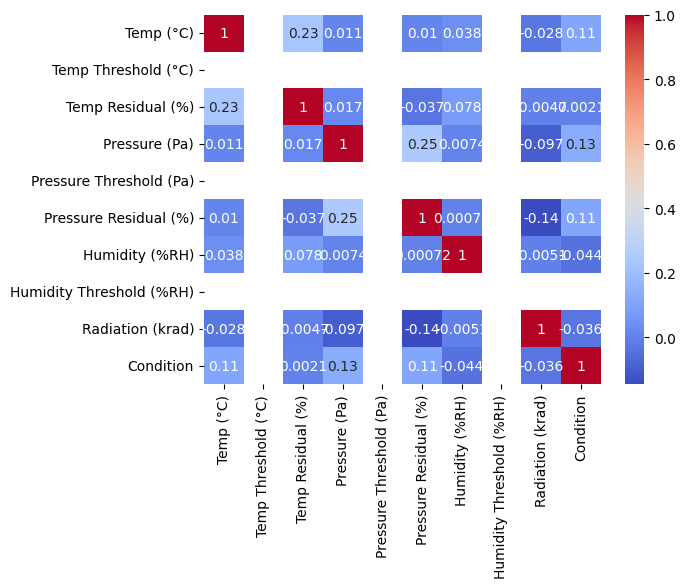

NameError: name 'PolynomialFeatures' is not defined

In [23]:
# Load dataset
file_path = "Updated_CubeSat_Sensor_Data.csv"
df = pd.read_csv(file_path) 
# Encode categorical variables
label_encoders = {}
for col in ["Temp Threshold (°C)", "Pressure Threshold (Pa)", "Humidity Threshold (%RH)", "Condition"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for later use

# Drop redundant features using correlation analysis
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

# Drop highly correlated features (keep only useful ones)
df = df.drop(columns=["Pressure Threshold (Pa)"])  # Example: Adjust as needed

# Split data into features and target variable
X = df.drop(columns=["Condition"])
y = df["Condition"]

# Add Polynomial Features (Feature Engineering)
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(X)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)


In [ ]:
# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [ ]:
# Define optimized neural network model
nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model with learning rate scheduling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nn_model.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Evaluate model
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int)
nn_accuracy = accuracy_score(y_test, y_pred_nn)
print("Neural Network Accuracy:", nn_accuracy)


c:\Users\surya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4558 - loss: 4.8234 - val_accuracy: 0.6396 - val_loss: 4.2610
Epoch 2/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5891 - loss: 4.1852 - val_accuracy: 0.6396 - val_loss: 3.8653
Epoch 3/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6670 - loss: 3.7431 - val_accuracy: 0.5135 - val_loss: 3.5274
Epoch 4/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6015 - loss: 3.4817 - val_accuracy: 0.6036 - val_loss: 3.2419
Epoch 5/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6699 - loss: 3.1427 - val_accuracy: 0.5495 - val_loss: 2.9957
Epoch 6/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6437 - loss: 2.9272 - val_accuracy: 0.6126 - val_loss: 2.7546
Epoch 7/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6997 - loss: 2.6576 - val_accuracy: 0.5495 - val_loss: 2.5731
Epoch 8/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6586 - loss: 2.5106 - val_accuracy: 0.5946 - 

In [ ]:
# Define Random Forest parameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)

# Train the best model
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Optimized Random Forest Accuracy:", rf_accuracy)


Optimized Random Forest Accuracy: 0.6756756756756757


In [ ]:
# Define and train XGBoost model
xgb_model = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("Optimized XGBoost Accuracy:", xgb_accuracy)
 

c:\Users\surya\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimized XGBoost Accuracy: 0.6216216216216216


In [ ]:
# Train CatBoost Model
catboost_model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
catboost_accuracy = accuracy_score(y_test, y_pred_catboost)
print("CatBoost Accuracy:", catboost_accuracy)


CatBoost Accuracy: 0.6216216216216216


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import shap
import optuna
import numpy as np

# 1️⃣ Train a temporary Random Forest model for feature importance
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_train, y_train)

# 2️⃣ Compute SHAP values
explainer = shap.TreeExplainer(rf_temp)
shap_values = explainer.shap_values(X_train)

# 3️⃣ Convert SHAP output to 2D (Fix the issue)
shap_importances = np.abs(shap_values).mean(axis=0)

# 4️⃣ Select the top 10 most important features
top_features = np.argsort(shap_importances)[-10:]

# 5️⃣ Reduce the dataset to only these features
X_train_shap = X_train[:, top_features]
X_test_shap = X_test[:, top_features]

# 6️⃣ Define the Optuna optimization function
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 200, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        bootstrap=True,
        oob_score=True,
        random_state=42
    )
    
    model.fit(X_train_shap, y_train)
    y_pred = model.predict(X_test_shap)
    return accuracy_score(y_test, y_pred)

# 7️⃣ Run Bayesian Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# 8️⃣ Train the final best model
best_rf_model = RandomForestClassifier(**study.best_params, class_weight='balanced', bootstrap=True, oob_score=True, random_state=42)
best_rf_model.fit(X_train_shap, y_train)
y_pred_rf = best_rf_model.predict(X_test_shap)

# 9️⃣ Print final accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("🔥 Optimized Random Forest Accuracy:", rf_accuracy)


c:\Users\surya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'X_train' is not defined